In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
# SELECT MAX(date) FROM measurement;
max_date = session.query(func.max(Measurement.date)).first()
max_date

('2017-08-23',)

Text(0, 0.5, 'Inches')

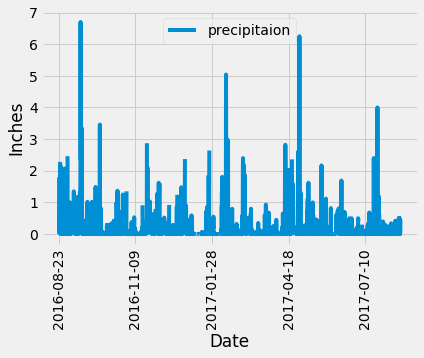

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 

# Starting from the most recent data point in the database. 
# Calculate the date one year from the last date in data set.
max_date1 = max_date[0].split("-")
max_date1
year = int(max_date1[0])
month = int(max_date1[1])
day = int(max_date1[2])
max_date_less_year = dt.date(year, month, day) - dt.timedelta(days=365)
# Perform a query to retrieve the data and precipitation scores
# SELECT date, prcp FROM measurement WHERE date >= max_date_less_year
prcp_last_year = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= max_date_less_year).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(prcp_last_year)
prcp_df = prcp_df.rename(columns ={0 : "Date", 1 : "precipitaion"})
# Sort the dataframe by date
prcp_df_sorted = prcp_df.sort_values("Date")
prcp_df_sorted

# Use Pandas Plotting with Matplotlib to plot the data
prcp_df_sorted.plot(x="Date", y="precipitaion", rot=90)
plt.ylabel("Inches")


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df_sorted.describe()

,precipitaion
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
# SELECT COUNT(station) FROM station
total_stations = session.query(func.count(Station.station)).all()
total_stations

[(9,)]

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(Measurement.station, func.count(Measurement.station)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
#select min(tobs), max(tobs), avg(tobs) from measurement where station=most_active
sel = [func.min(Measurement.tobs),
       func.max(Measurement.tobs),
       func.avg(Measurement.tobs)
      ]
most_active = session.query(*sel).\
                filter(Measurement.station == most_active_station).all()
most_active

[(54.0, 85.0, 71.66378066378067)]

Text(0.5, 0, 'Temperature')

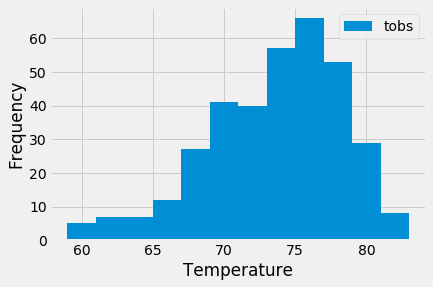

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
# SELECT tobs FROM measurement WHERE date >= max_date_less_year AND station=most_active_station
temp_last_year = session.query(Measurement.tobs).filter(Measurement.date >= max_date_less_year).\
                                                 filter(Measurement.station==most_active_station).all()
temp_last_year
temp_df = pd.DataFrame(temp_last_year)
temp_df.rename(columns={0: "tobs"}, inplace=True)
temp_df
temp_df.plot(kind="hist", bins=12)
plt.xlabel("Temperature")

# Close Session

In [17]:
# Close Session
session.close()